# Figure 3

In [10]:
import os
import gc
import glob
import tqdm
import hdf5plugin
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import issparse
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from PIL import Image
Image.MAX_IMAGE_PIXELS = None


In [ ]:
def get_R(data1,data2, dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[1]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    num_breaks: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

def top_predictable_genes(df_all, dataset, method, num=5,):
    """
    input the results from the make_res function.
    output the top predictable genes with the number of positive Pearson correlation values.
    num is the number of top predictable genes.
    """
    df = df_all[df_all["Method"]==method]
    if num == "pos":
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)
    top5_genes = list(top5_df.index)
    
    # Subset the results according to top predictable gene
    num_pos = []
    for g in top5_genes:
        subset_df = df[df["Gene"]==g]
        count_positive_corr = subset_df[subset_df['Pearson correlation'] > 0].shape[0]
        # print(f'Number of positive Pearson correlation values: {count_positive_corr}')
        num_pos.append(int(count_positive_corr))
    top5_df["Number of consistent samples"] = num_pos
    top5_df["Method"] = method
    top5_df["Dataset"] = dataset
    top5_df = top5_df[[(           'Method',       ''),
            (                     'Dataset',       ''),
            ('Number of consistent samples',       ''),
            (         'Pearson correlation',   'mean'),
            (         'Pearson correlation', 'median'),
            (         'Pearson correlation', 'min'),
            (         'Pearson correlation',    'max'),
            (         'Pearson correlation',    'std'),
            
            ]]

    return top5_df
    
def make_non_MI_val_res(dataset_name, colornorm, Methods):
    for method in tqdm.tqdm(Methods):
        file_path = f"../Results/{dataset_name}/gt_{method}_{dataset_name}_{colornorm}_func_val.h5ad"
        if os.path.exists(file_path):
            data1 = sc.read_h5ad(f"../Results/{dataset_name}/gt_{method}_{dataset_name}_{colornorm}_func_val.h5ad")
            data2 = sc.read_h5ad(f"../Results/{dataset_name}/pred_{method}_{dataset_name}_{colornorm}_func_val.h5ad")
            data2.var_names = data1.var_names
            pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
            SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
            ssim_score = get_ssim(data1, data2)
            cosine_score = get_cosine(data1, data2)
            PCC_BC_Visium = {
            "Gene": np.load("../Dataset/Gene_list/Gene_list_func_BC_visium.npy").tolist(),
            "Pearson correlation": pcc,
            "PCC_PValue": PCC_PValue,
            "Spearmanr correlation": SPC,
            "SPC_PValue": SPC_PValue,
            "SSIM_Score": ssim_score,
            "Cosine_Score": cosine_score,
            "Dataset": [dataset_name]*len(pcc),
            "Method": [method]*len(pcc),}
            
            PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
            if not os.path.isdir(f"../Results/{dataset_name}"):
                os.mkdir(f"../Results/{dataset_name}")
            PCC_BC_Visium.to_csv(f"../Results/{dataset_name}/{method}_{dataset_name}_{colornorm}_non-MI_val.csv")
        else:
            print(f"The file {file_path} does not exist. Skipping.")
    print("Organize the results into summary file!")
    res = glob.glob(f"../Results/{dataset_name}/*_non-MI_val.csv")
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])
    df.reset_index(inplace=True)
    df.to_csv(f"../Results/Summary/{dataset_name}_summary_non-MI_val.csv")
    gc.collect()
    return df

def make_non_MI_res(dataset_name, colornorm, Methods):
    for method in tqdm.tqdm(Methods):
        file_path = f"../Results/{dataset_name}/gt_{method}_{dataset_name}_{colornorm}_func.h5ad"
        if os.path.exists(file_path):
            data1 = sc.read_h5ad(f"../Results/{dataset_name}/gt_{method}_{dataset_name}_{colornorm}_func.h5ad")
            data2 = sc.read_h5ad(f"../Results/{dataset_name}/pred_{method}_{dataset_name}_{colornorm}_func.h5ad")
            spatial_matrix = np.load(f"../Results/{dataset_name}/spatial_loc_{method}_{dataset_name}_{colornorm}_func.npy")
            data2.var_names = data1.var_names
            pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
            SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
            ssim_score = get_ssim(data1, data2)
            cosine_score = get_cosine(data1, data2)
            PCC_BC_Visium = {
            "Gene": np.load("../Dataset/Gene_list/Gene_list_func_BC_visium.npy").tolist(),
            "Pearson correlation": pcc,
            "PCC_PValue": PCC_PValue,
            "Spearmanr correlation": SPC,
            "SPC_PValue": SPC_PValue,
            "SSIM_Score": ssim_score,
            "Cosine_Score": cosine_score,
            "Dataset": [dataset_name]*len(pcc),
            "Method": [method]*len(pcc),}
            
            PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
            if not os.path.isdir(f"../Results/{dataset_name}"):
                os.mkdir(f"../Results/{dataset_name}")
            PCC_BC_Visium.to_csv(f"../Results/{dataset_name}/{method}_{dataset_name}_{colornorm}_non-MI.csv")
        else:
            print(f"The file {file_path} does not exist. Skipping.")
    print("Organize the results into summary file!")
    res = glob.glob(f"../Results/{dataset_name}/*_non-MI.csv")
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])
    df.reset_index(inplace=True)
    df.to_csv(f"../Results/Summary/{dataset_name}_summary_non-MI.csv")
    gc.collect()
    return df
    

In [ ]:
# It is not necessary to run the following code if the results are already generated.
dataset_name = "Alex_BC_visium"
colornorm = "raw"
Methods = ["hist2st", "histogene", "stnet", "deeppt", "stimage", "bleep", "deepspace"] # "hist2st", "histogene", "stnet", "deeppt", "stimage", "bleep", "deepspace"
df_Alex = make_non_MI_val_res(dataset_name, colornorm, Methods)

dataset_name = "tenx_BC_visium"
colornorm = "raw"
Methods = ["hist2st", "histogene", "stnet", "deeppt", "stimage", "bleep", "deepspace"] # "hist2st", "histogene", "stnet", "deeppt", "stimage", "bleep", "deepspace"
df_tenx = make_non_MI_val_res(dataset_name, colornorm, Methods)

dataset_name = "Alex_BC_visium"
colornorm = "raw"
Methods = ["hist2st", "histogene", "stnet", "deeppt", "stimage", "bleep", "deepspace"]
df_Alex = make_non_MI_res(dataset_name, colornorm, Methods)

dataset_name = "tenx_BC_visium"
colornorm = "raw"
Methods = ["hist2st", "histogene", "stnet", "deeppt", "stimage", "bleep", "deepspace"]
df_tenx = make_non_MI_res(dataset_name, colornorm, Methods)


In [7]:
dataset_name = "tenx_BC_visium"
df_tenx_test = pd.read_csv(f"../Results/Summary/{dataset_name}_summary_non-MI.csv", index_col=[0])
df_tenx_val = pd.read_csv(f"../Results/Summary/{dataset_name}_summary_non-MI_val.csv", index_col=[0])
df_tenx_val = df_tenx_val.replace({"tenx_BC_visium": "ID-10X"})
df_tenx_test = df_tenx_test.replace({"tenx_BC_visium": "OOD-Wu_etal"})
df_tenx = pd.concat([df_tenx_val, df_tenx_test])

dataset_name = "Alex_BC_visium"
df_Alex_test = pd.read_csv(f"../Results/Summary/{dataset_name}_summary_non-MI.csv", index_col=[0])
df_Alex_val = pd.read_csv(f"../Results/Summary/{dataset_name}_summary_non-MI_val.csv", index_col=[0])
df_Alex_val = df_Alex_val.replace({"Alex_BC_visium": "ID-Wu_etal"})
df_Alex_test = df_Alex_test.replace({"Alex_BC_visium": "OOD-10X"})
df_Alex = pd.concat([df_Alex_val, df_Alex_test])
df = pd.concat([df_Alex, df_tenx])
df


,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Dataset,Method
0,0,TCL1A,0.056934,7.658227e-05,0.060314,3.023127e-05,-0.005128,-0.028719,ID-Wu_etal,hist2st
1,1,NODAL,0.001109,4.706190e-01,0.006181,3.406562e-01,-0.000011,-0.012186,ID-Wu_etal,hist2st
2,2,MCM7,0.234017,2.586530e-56,0.236843,1.140490e-57,0.161462,0.793654,ID-Wu_etal,hist2st
3,3,COMMD3,0.020784,8.362597e-02,0.012452,2.040233e-01,0.015438,0.606745,ID-Wu_etal,hist2st
4,4,VEGFC,0.035329,9.435606e-03,0.049163,5.406325e-04,0.006798,0.170613,ID-Wu_etal,hist2st
...,...,...,...,...,...,...,...,...,...,...
11405,1625,CCL27,0.031692,6.759681e-05,0.032346,4.897000e-05,-0.000499,-0.003642,OOD-Wu_etal,stnet
11406,1626,HLA-DQA1,0.104311,1.138445e-36,0.081452,4.452535e-23,0.109991,0.472223,OOD-Wu_etal,stnet
11407,1627,WNT3,0.036540,5.384900e-06,0.034797,1.388412e-05,0.007329,0.120309,OOD-Wu_etal,stnet
11408,1628,NASP,0.097471,2.989075e-32,0.082976,7.028668e-24,0.080075,0.519549,OOD-Wu_etal,stnet


In [9]:
df = pd.read_csv(f"../Results/Summary/ID_BC_visium_performance.csv", index_col=[0])

In [10]:
df = df.replace({
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE",
    "tenx_BC_visium": "10X_BC",
})
Method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']
df['Method'] = pd.Categorical(df['Method'], categories=Method_order, ordered=True)


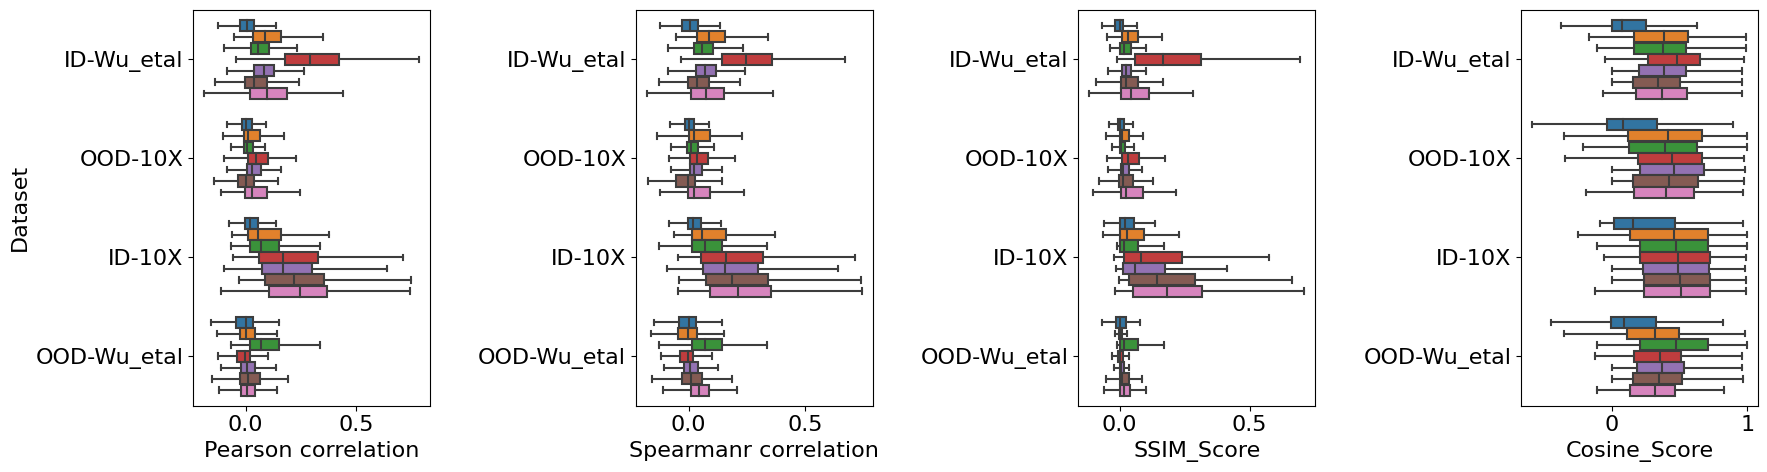

58312

In [12]:
plt.rcParams.update({'font.size': 16})
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 4, figsize=(18, 5))

# Plot the first figure
sns.boxplot(x='Pearson correlation', y='Dataset', hue="Method", data=df, orient="h", ax=axs[0], showfliers=False)
axs[0].get_legend().remove()

# Plot the second figure
sns.boxplot(x='Spearmanr correlation', y='Dataset', hue="Method", data=df, ax=axs[1], showfliers=False)
axs[1].get_legend().remove()
axs[1].set_ylabel('')  # Remove y-axis label

# Plot the third figure
sns.boxplot(x='SSIM_Score', y='Dataset', hue="Method", data=df, ax=axs[2], showfliers=False)
axs[2].get_legend().remove()
axs[2].set_ylabel('')  # Remove y-axis label


# Plot the fourth figure
sns.boxplot(x='Cosine_Score', y='Dataset', hue="Method", data=df, ax=axs[3], showfliers=False)
axs[3].get_legend().remove()
axs[3].set_ylabel('')  # Remove y-axis label

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.savefig(f"S4.pdf")
plt.show()
gc.collect()


## Figure 3 b)


In [ ]:
adata_path = glob.glob("../Dataset/BC_visium/*h5ad")[:-1]
adata_path


In [11]:
# List of file paths for your 6 images
names = [i.split("/")[-1].split(".")[0] for i in adata_path]
image_paths = [f"../Dataset/BC_visium/{name}/image.tif" for name in names]

images = []
for image_path in image_paths:
    img = np.array(Image.open(image_path))
    images.append(img)

R, G, B = {}, {}, {}
for i in range(len(names)):
    name = names[i]
    R[name+"_mean"] = images[i][:,:,0].mean()
    G[name+"_mean"] = images[i][:,:,1].mean()
    B[name+"_mean"] = images[i][:,:,2].mean()

df = pd.concat([pd.DataFrame(R, index=["Red"]),
                pd.DataFrame(G, index=["Green"]),
                pd.DataFrame(B, index=["Blue"]),
               ]).T
df["Slide"] = names

# Melt the DataFrame
melted_df = pd.melt(df, id_vars=['Slide'], var_name='Color', value_name='Mean Value')

# Display the melted DataFrame
melted_df

,Slide,Color,Mean Value
0,1142243F,Red,145.480131
1,CID4535,Red,224.382476
2,CID4290,Red,213.785709
3,1160920F,Red,162.379559
4,CID4465,Red,228.243079
5,block2,Red,170.066569
6,block1,Red,171.196682
7,CID44971,Red,226.954537
8,1142243F,Green,140.776941
9,CID4535,Green,193.284453


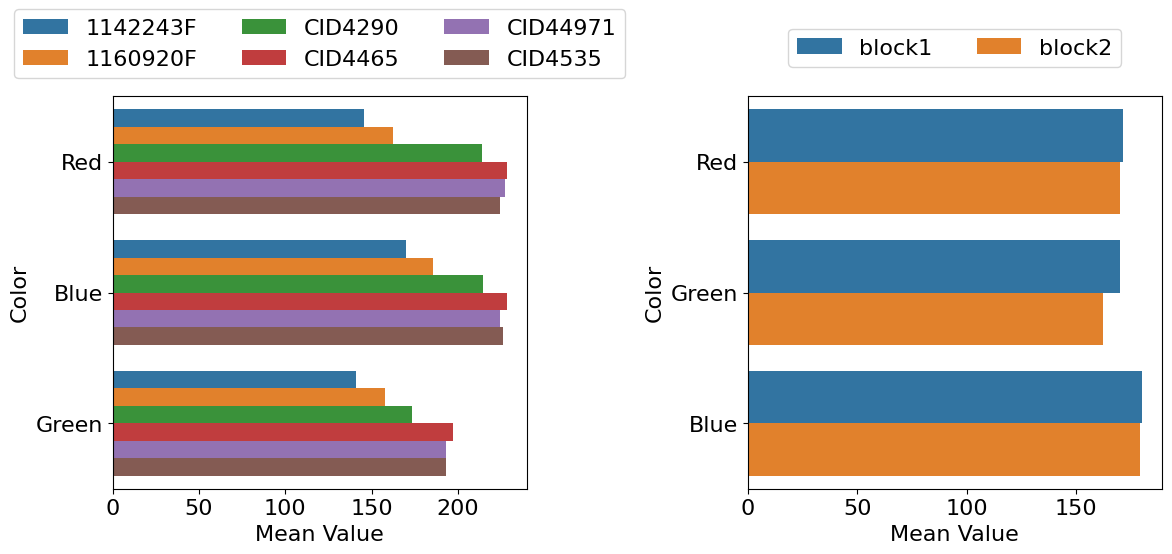

In [12]:
plt.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the barplot
df_alex_color = melted_df[~melted_df["Slide"].isin(["block1", "block2"])]
df_alex_color = df_alex_color.sort_values("Slide")
sns.barplot(df_alex_color, y="Color", x="Mean Value", orient="h",
            hue="Slide", ax=axs[0])
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)


df_10x_color = melted_df[melted_df["Slide"].isin(["block1", "block2"])]
df_10x_color = df_10x_color.sort_values("Slide")
sns.barplot(df_10x_color, y="Color", x="Mean Value", orient="h",
            hue="Slide", ax=axs[1])

# Move the legend to the upper center horizontally
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.tight_layout()

# plt.savefig("Figure3_b.pdf", dpi=300)
plt.show()


## Figure 3 c)

In [ ]:
# Breast cancer BC_visium dataset
dataset_name = "BC_visium"
adata_path = glob.glob("../Dataset/BC_visium/*h5ad")[:-1]
target_gene_list = np.load("../Dataset/Gene_list/Gene_list_func_BC_visium.npy").tolist()
adata_dict = {i.split("/")[-1].split(".")[0]: sc.read_h5ad(i)[:,target_gene_list] for i in adata_path}


In [ ]:
# Compute QC metrics
for i in range(len(list(adata_dict.keys()))):
    sc.pp.calculate_qc_metrics(adata_dict[list(adata_dict.keys())[i]], log1p=False, inplace=True)

# Plot QC metrics n_genes_by_counts
df = []
for i in range(len(list(adata_dict.keys()))):
    x = adata_dict[list(adata_dict.keys())[i]].obs[["n_genes_by_counts"]]
    x["Slide"] = list(adata_dict.keys())[i]
    df.append(x)
df = pd.concat(df)

125

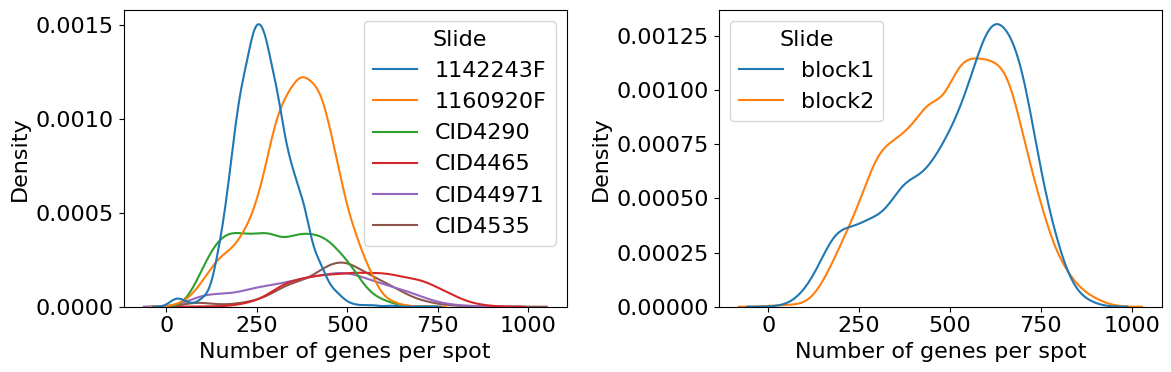

In [15]:
df["Number of genes per spot"] = df["n_genes_by_counts"]
df_alex = df[~df["Slide"].isin(["block1", "block2"])]
df_alex = df_alex.sort_values("Slide")
df_10x = df[df["Slide"].isin(["block1", "block2"])]
df_10x = df_10x.sort_values("Slide")

plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the first subplot
sns.kdeplot(df_alex, x="Number of genes per spot", hue="Slide", ax=axs[0])

# Plotting the second subplot
sns.kdeplot(df_10x, x="Number of genes per spot", hue="Slide", ax=axs[1])

plt.tight_layout()
plt.savefig("ID_expression_detection.pdf", dpi=300)
gc.collect()
# plt.show()

## Figure 3 d)

In [13]:
def top_predictable_genes(df_results: pd.DataFrame, dataset: str, method: str, num: int = 5) -> pd.DataFrame:
    """
    Extracts the top predictable genes based on Pearson correlation for a specific method and dataset.

    Parameters:
        - df_results (pd.DataFrame): The DataFrame containing the results from the make_res function.
        - dataset (str): The dataset name.
        - method (str): The method name.
        - num (int, optional): The number of top predictable genes or "pos" for all positive Pearson correlation values.

    Returns:
        pd.DataFrame: DataFrame containing the top predictable genes and related statistics.
    """
    df = df_results[df_results["Method"] == method]

    if num == "pos":
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(
            ['median', 'mean', 'max', 'min', 'std']
        ).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)

    top_genes = list(top_df.index)

    # Calculate the number of consistent samples for each top gene
    num_pos = [df[df["Gene"] == g]['Pearson correlation'].gt(0).sum() for g in top_genes]

    # Create the final DataFrame with relevant columns
    top_df["Number of consistent samples"] = num_pos
    top_df["Method"] = method
    top_df["Dataset"] = dataset
    top_df = top_df[[('Method', ''), ('Dataset', ''), ('Number of consistent samples', ''),
                     ('Pearson correlation', 'mean'), ('Pearson correlation', 'median'),
                     ('Pearson correlation', 'min'), ('Pearson correlation', 'max'),
                     ('Pearson correlation', 'std')]]

    return top_df


In [14]:
dataset_name = "ID-Wu_etal"
methods = ["DeepPT", "Hist2ST", "HistoGene", "STimage", "BLEEP", "STnet", "DeepSpaCE"]
gene_sets = []
method = methods[0]
top_predictable_genes(df, dataset_name, method, num=500)


Method     Dataset Number of consistent samples Pearson correlation  \
                                                                       mean   
Gene                                                                          
FOXA1   DeepPT  ID-Wu_etal                            3            0.313708   
XBP1    DeepPT  ID-Wu_etal                            3            0.308036   
CLU     DeepPT  ID-Wu_etal                            3            0.251051   
HSPA1A  DeepPT  ID-Wu_etal                            3            0.326050   
GATA3   DeepPT  ID-Wu_etal                            3            0.304509   
...        ...         ...                          ...                 ...   
SETD2   DeepPT  ID-Wu_etal                            4            0.167220   
OSMR    DeepPT  ID-Wu_etal                            4            0.106694   
ASF1A   DeepPT  ID-Wu_etal                            4            0.132201   
SIN3A   DeepPT  ID-Wu_etal                            3            0.138987   
SDC2    DeepPT  ID-Wu_etal                            3            0.105263   

                                                
          median       min       max       std  
Gene                                            
FOXA1   0.400622 -0.232678  0.686266  0.398068  
XBP1    0.386921 -0.269365  0.727669  0.433815  
CLU     0.381581 -0.281347  0.522390  0.368109  
HSPA1A  0.377184 -0.166627  0.716459  0.366931  
GATA3   0.374526 -0.274613  0.743599  0.423979  
...          ...       ...       ...       ...  
SETD2   0.120443  0.010299  0.417695  0.177805  
OSMR    0.120408  0.009911  0.176050  0.077518  
ASF1A   0.120397  0.038400  0.249612  0.099338  
SIN3A   0.120154 -0.017762  0.333401  0.148148  
SDC2    0.120061 -0.067307  0.248236  0.138187  

[500 rows x 8 columns]

In [24]:
# Specify the directory for functional gene results
functional_results_directory = "../Results/Summary/"

# Specify the directory for predictable gene results
predictable_results_directory = "../Results/Predictable_res/"

# List of dataset names
datasets = ['ID-Wu_etal', 'OOD-10X', 'ID-10X', 'OOD-Wu_etal']

# Iterate over datasets
for dataset_name in datasets:
    # Read the functional gene results for the current dataset
    df_func = pd.read_csv(os.path.join(functional_results_directory, f"ID_BC_visium_performance.csv"))
    df_func = df_func.replace({
        'deeppt': "DeepPT",
        'histogene': "HisToGene",
        'His2gene': "HisToGene",
        'stnet': "STnet",
        'hist2st': "Hist2ST",
        'stimage': "STimage",
        'bleep': "BLEEP",
        'deepspace': "DeepSpaCE",
    })
    # List of methods
    methods = ['Hist2ST', 'BLEEP', 'STnet', 'DeepPT', 'DeepSpaCE', 'STimage', 'HisToGene']

    # Get predictable genes for each method
    predictable_genes_sets = [set(top_predictable_genes(df_func, dataset_name, method, num=500).index) for method in methods]

    # Find the intersection of predictable genes across all methods
    predictable_genes = list(set.intersection(*predictable_genes_sets))
    print(f"There are {len(predictable_genes)} genes that are predictable by all methods for {dataset_name}.")

    # Subset the original DataFrame for predictable genes
    df_predictable = df_func[df_func["Gene"].isin(predictable_genes)].reset_index(drop=True)

    # Save the results for predictable genes
    predictable_results_path = os.path.join(predictable_results_directory, f"predictable_{dataset_name}_ID_BCvisium.csv")
    df_predictable.to_csv(predictable_results_path)

# Load the results of predictable genes
predictable_results_glob = os.path.join(predictable_results_directory, "predictable_*_ID_BCvisium.csv")
df_combined_predictable = pd.concat([pd.read_csv(r, index_col=[0]) for r in glob.glob(predictable_results_glob)], ignore_index=True)
df_combined_predictable


There are 101 genes that are predictable by all methods for ID-Wu_etal.
There are 101 genes that are predictable by all methods for OOD-10X.
There are 101 genes that are predictable by all methods for ID-10X.
There are 101 genes that are predictable by all methods for OOD-Wu_etal.


,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Dataset,Method
0,3,3,COMMD3,0.020784,8.362597e-02,0.012452,2.040233e-01,0.015438,0.606745,ID-Wu_etal,Hist2ST
1,15,15,PCNA,0.104725,1.504276e-12,0.107729,3.522033e-13,0.077064,0.777237,ID-Wu_etal,Hist2ST
2,34,34,TPX2,0.107407,4.123244e-13,0.101464,6.951451e-12,0.067978,0.579604,ID-Wu_etal,Hist2ST
3,52,52,RRM2,0.147991,2.363362e-23,0.138747,9.900940e-21,0.072436,0.600209,ID-Wu_etal,Hist2ST
4,66,66,SMC4,-0.019480,9.022433e-01,-0.020151,9.097204e-01,-0.006870,0.616440,ID-Wu_etal,Hist2ST
...,...,...,...,...,...,...,...,...,...,...,...
11307,11353,1573,UBE3A,-0.073046,1.000000e+00,-0.069001,1.000000e+00,-0.044979,0.094511,OOD-Wu_etal,STnet
11308,11358,1578,BRD8,0.083012,6.726715e-24,0.088054,1.166355e-26,0.078062,0.487196,OOD-Wu_etal,STnet
11309,11386,1606,PFN1,-0.122649,1.000000e+00,-0.122009,1.000000e+00,-0.086692,0.879143,OOD-Wu_etal,STnet
11310,11399,1619,RHOA,-0.315286,1.000000e+00,-0.322145,1.000000e+00,-0.286422,0.749343,OOD-Wu_etal,STnet


In [25]:
df = df_combined_predictable

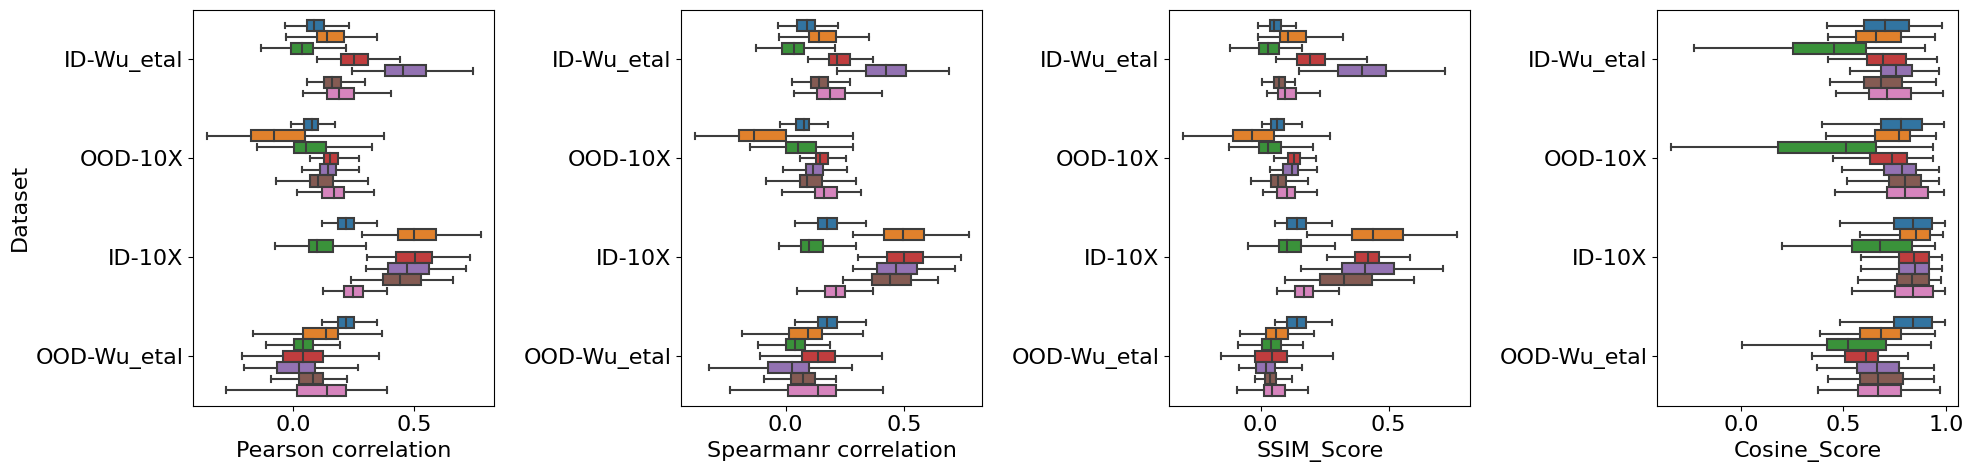

82892

In [26]:
plt.rcParams.update({'font.size': 16})
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot the first figure
sns.boxplot(x='Pearson correlation', y='Dataset', hue="Method", data=df, orient="h", ax=axs[0], showfliers=False)
axs[0].get_legend().remove()

# Plot the second figure
sns.boxplot(x='Spearmanr correlation', y='Dataset', hue="Method", data=df, ax=axs[1], showfliers=False)
axs[1].get_legend().remove()
axs[1].set_ylabel('')  # Remove y-axis label

# Plot the third figure
sns.boxplot(x='SSIM_Score', y='Dataset', hue="Method", data=df, ax=axs[2], showfliers=False)
axs[2].get_legend().remove()
axs[2].set_ylabel('')  # Remove y-axis label


# Plot the fourth figure
sns.boxplot(x='Cosine_Score', y='Dataset', hue="Method", data=df, ax=axs[3], showfliers=False)
axs[3].get_legend().remove()
axs[3].set_ylabel('')  # Remove y-axis label

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
# plt.savefig(f"Figure3_d.pdf")
plt.show()
gc.collect()


## Figure 3 e)

In [16]:
df_OOD = pd.concat(pd.read_csv(r, index_col=[0]) for r in glob.glob("../Results/Summary/Generalizability/*_*_*_*_summary_nonMI_mean.csv"))

# Define mapping dictionaries for model and dataset names
model_mapping = {
    'deeppt': "DeepPT",
    'histogene': "HisToGene",
    'His2gene': "HisToGene",
    'stnet': "STnet",
    'hist2st': "Hist2ST",
    'stimage': "STimage",
    'bleep': "BLEEP",
    'deepspace': "DeepSpaCE"
}

# Replace model and dataset names in the DataFrame
df_OOD.replace({'Method': model_mapping,}, inplace=True)

# Define the order for Dataset and Method columns
dataset_order = ['BC_Her2ST_BC_visium', 'BC_visium_BC_Her2ST', 'Skin_cSCC_Skin_Melanoma', 'Skin_cSCC_BC_Her2ST', 'Skin_Melanoma_BC_visium', 'Skin_Melanoma_Skin_cSCC']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

# Use pd.Categorical directly during DataFrame creation
df_OOD['Dataset'] = pd.Categorical(df_OOD['Dataset'], categories=dataset_order, ordered=True)
df_OOD['Method'] = pd.Categorical(df_OOD['Method'], categories=method_order, ordered=True)

df_ID = pd.read_csv("../Results/Summary/ID_func_metrics.csv")
df_ID = df_ID[df_ID["Dataset"].isin(["BC_Her2ST", "BC_Visium", "Skin_Melanoma", "Skin_cSCC"])]
df2 = pd.concat([df_ID, df_OOD])

dataset_mapping = {
    'BC_Her2ST': "BC_Her2ST-ID",
    'Skin_cSCC': "Skin_cSCC-ID",
    'Skin_Melanoma': "Skin_Melanoma-ID",
    'BC_Visium': "BC_Visium-ID",
    'Skin_cSCC_BC_Her2ST': "BC_Her2ST-OOD",
    'Skin_Melanoma_Skin_cSCC': "Skin_cSCC-OOD",
    'Skin_cSCC_Skin_Melanoma': "Skin_Melanoma-OOD",
    'Skin_Melanoma_BC_visium': "BC_Visium-OOD",
}

df2.replace({'Dataset': dataset_mapping,}, inplace=True)

dataset_order = ['BC_Her2ST-ID', 'BC_Her2ST-OOD', 'BC_visium_BC_Her2ST', 'BC_Visium-ID', 'BC_Visium-OOD', 'BC_Her2ST_BC_visium', 'Skin_Melanoma-ID',  'Skin_Melanoma-OOD', 'Skin_cSCC-ID', 'Skin_cSCC-OOD']
method_order = ['STnet', 'HisToGene', 'Hist2ST', 'DeepSpaCE', 'STimage', 'BLEEP', 'DeepPT']

df2['Dataset'] = pd.Categorical(df2['Dataset'], categories=dataset_order, ordered=True)
df2['Method'] = pd.Categorical(df2['Method'], categories=method_order, ordered=True)

df3 = df2[df2['Dataset'].isin(['BC_Her2ST-ID', 'BC_Her2ST_BC_visium', 'BC_Visium-ID', 'BC_visium_BC_Her2ST'])]
dataset_order = ['BC_Her2ST-ID', 'BC_Her2ST_BC_visium', 'BC_Visium-ID', 'BC_visium_BC_Her2ST']
df3['Dataset'] = pd.Categorical(df3['Dataset'], categories=dataset_order, ordered=True)


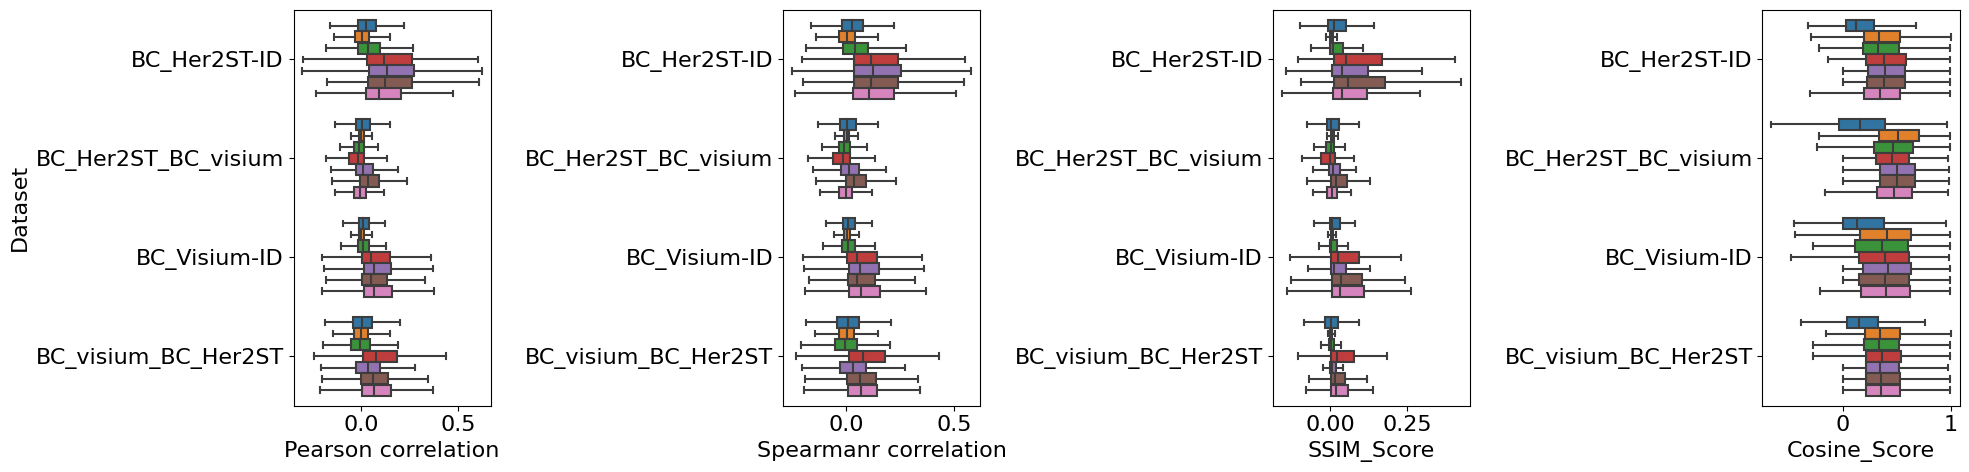

8025

In [17]:
plt.rcParams.update({'font.size': 16})
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot the first figure
sns.boxplot(x='Pearson correlation', y='Dataset', hue="Method", data=df3, orient="h", ax=axs[0], showfliers=False)
axs[0].get_legend().remove()

# Plot the second figure
sns.boxplot(x='Spearmanr correlation', y='Dataset', hue="Method", data=df3, ax=axs[1], showfliers=False)
axs[1].get_legend().remove()
axs[1].set_ylabel('')  # Remove y-axis label

# Plot the third figure
sns.boxplot(x='SSIM_Score', y='Dataset', hue="Method", data=df3, ax=axs[2], showfliers=False)
axs[2].get_legend().remove()
axs[2].set_ylabel('')  # Remove y-axis label


# Plot the fourth figure
sns.boxplot(x='Cosine_Score', y='Dataset', hue="Method", data=df3, ax=axs[3], showfliers=False)
axs[3].get_legend().remove()
axs[3].set_ylabel('')  # Remove y-axis label

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
# plt.savefig(f"Figure3_e.pdf")
plt.show()
gc.collect()
